# 2022年8月2日00:42:57

想象有这样一个二维空间场景：把一个高温的，比如为600℃，圆形铁饼放在一个正方形的空间内，该空间内的环境温度是固定的，比如为室温25℃，或者0℃。研究经过一个固定的时间，比如1小时，后铁饼的温度。

# 1. 物理模型

传热方程如下：
$$\frac{\partial T}{\partial t}=\alpha (\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2})$$

其中$\alpha=\frac{k}{\rho c}$为热扩散系数，$k,\rho,c$分别为材料的热导率($\frac{W}{m\cdot K}$)，密度($\frac{kg}{m^3}$)，比热容($\frac{J}{kg \cdot K}$)

不考虑对流和热辐射，且假定材料为铁，半径为0.2，温度为600℃；环境空间边长为1，温度为25℃

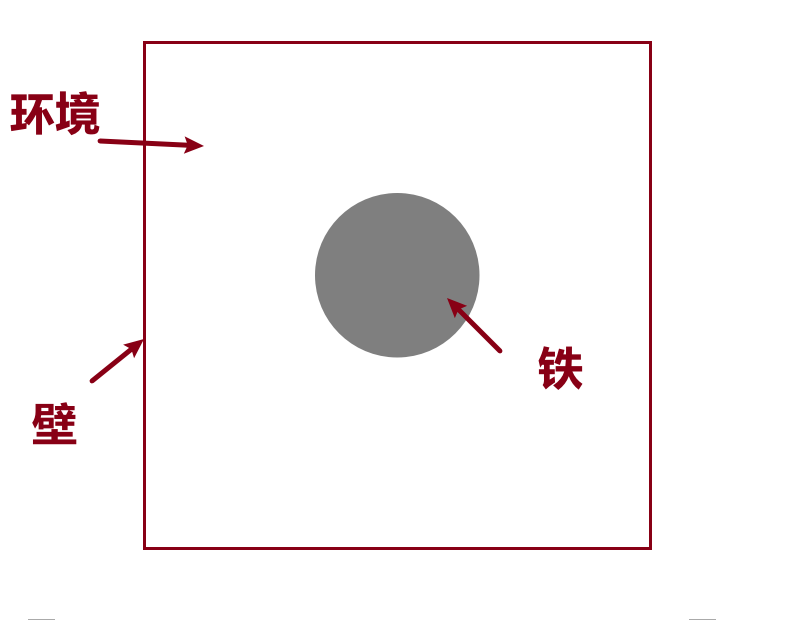

# 2. 离散化

对于时间的离散

$$\frac{\partial T}{\partial t}=\frac{T^{m+1}-T^{m}}{\Delta t}$$

其中$T^m$表示当前时刻的温度，$T^{m+1}$表示下一个时刻的温度

对于空间的离散

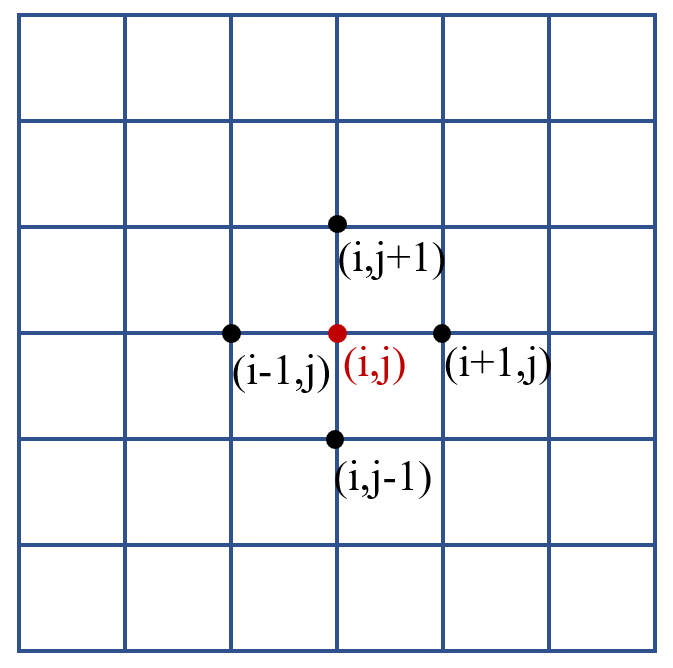

根据公式$\frac{\partial T}{\partial x}=\frac{T_{i+1}-T_i}{\Delta x}=\frac{T_{i}-T_{i-1}}{\Delta x}$可以推导出$\frac{\partial^2 T}{\partial x^2}=\frac{\partial}{\partial x}(\frac{\partial T}{\partial x})=\frac{T_{i+1}-2T_i+T_{i-1}}{\Delta x^2}$

最后可得：
$$ \frac{T_{i,j}^{(m+1)} - T_{i,j}^{(m)}}{\Delta t}=\alpha \left( \frac{T_{i+1,j}^{(m+1)} -2T_{i,j}^{(m+1)} + T_{i-1,j}^{(m+1)}}{\Delta x^2} + \frac{T_{i,j+1}^{(m+1)} -2T_{i,j}^{(m+1)} + T_{i,j-1}^{(m+1)}}{\Delta y^2}\right) $$

令$\Delta x=\Delta y$，移项可得：
$$\frac{T_{i,j}^{(m+1)} - T_{i,j}^{(m)}}{\Delta t} = \alpha \left( \frac{T_{i+1,j}^{(m+1)} + T_{i-1,j}^{(m+1)}+T_{i,j+1}^{(m+1)}+T_{i,j-1}^{(m+1)}-4T_{i,j}^{(m+1)} }{\Delta x^2}\right)$$

继续化简：
$$T_{i,j}^{(m+1)}-T_{i,j}^{(m)}=\frac{\alpha \Delta t}{\Delta x^2}
\left(T_{i+1,j}^{(m+1)}+T_{i-1,j}^{(m+1)}+T_{i,j+1}^{(m+1)}+T_{i,j-1}^{(m+1)}-4T_{i,j}^{(m+1)}\right)$$

令$F_o=\frac{\alpha \Delta t}{\Delta x^2}$，并把同一时刻的项放在同侧可得：
$$T_{i,j}^{(m+1)}-F_o
\left(T_{i+1,j}^{(m+1)}+T_{i-1,j}^{(m+1)}+T_{i,j+1}^{(m+1)}+T_{i,j-1}^{(m+1)}-4T_{i,j}^{(m+1)}\right)=T_{i,j}^{(m)}$$

# 3. 编程

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

## 1. 设定材料参数

In [2]:
k=76.2    # 热导率 W/(m*K)
rho=7870  # 密度 kg/(m**3)
c=440     # 比热容 J/(kg*K)
alpha=k/rho/c   # 热扩散系数 m**2/s
alpha

2.200531361903662e-05

## 2. 设定迭代参数

In [3]:
n=60
x,y=np.linspace(0,1,n),np.linspace(0,1,n)

X,Y=np.meshgrid(x,y)
Z=((X-0.5)**2+(Y-0.5)**2<=0.04)

T_am=25
T_Fe=600
T=np.ones((n,n))*T_am  # 环境温度
T[Z]=T_Fe             # 铁饼温度

t=3600         # 也就是 1h
dt=1
times=int(t/dt)        # 循环次数
storage=360       # 要存储的时刻次数
f=times/storage   # 存储判断条件

dx=x[1]-x[0]
F=(alpha*dt)/(dx**2)
F,times,f

(0.07660049670786648, 3600, 10.0)

为了保证可解，对于二维情况，要保证$s<\frac{1}{4}$

## 2.2设定存储变量

In [4]:

TT=np.zeros((storage+1,n,n))

TT[0]=T

## 3. 检查参数

## 3.1 空间

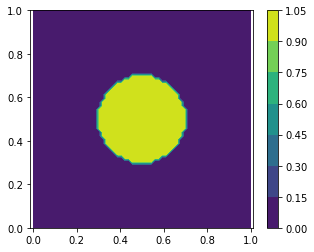

In [5]:
plt.figure(figsize=(5,4))
plt.contourf(X,Y,Z)
plt.colorbar()
plt.axis('equal')
plt.show()

## 3.2 初始温度分布

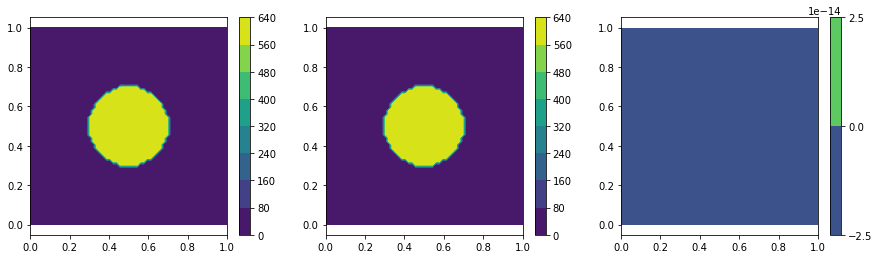

In [6]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
ax0=axes[0]
a0=ax0.contourf(X,Y,T)
ax0.axis('equal')

ax1=axes[1]
a1=ax1.contourf(X,Y,TT[0])
ax1.axis('equal')

ax2=axes[2]
a2=ax2.contourf(X,Y,TT[18]) # 随便挑的
ax2.axis('equal')
fig.colorbar(a0,ax=ax0)
fig.colorbar(a1,ax=ax1)
fig.colorbar(a2,ax=ax2)
plt.show()

## 4. 开始迭代 

$$T_{i,j}^{(m+1)}-F_o
\left(T_{i+1,j}^{(m+1)}+T_{i-1,j}^{(m+1)}+T_{i,j+1}^{(m+1)}+T_{i,j-1}^{(m+1)}-4T_{i,j}^{(m+1)}\right)=T_{i,j}^{(m)}$$

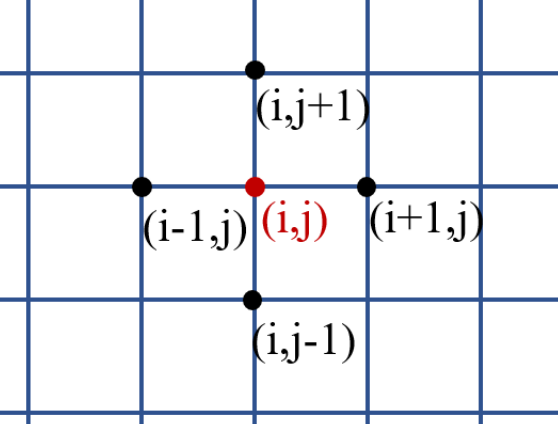

因为要求解线性方程组，需要对节点进行编号，用以下方式表示：  
* 1. $idd->(i,j-1)->下$  
* 2. $idl->(i-1,j)->左$
* 3. $idm->(i,j)->中$
* 4. $idr->(i+1,j)->右$
* 5. $idu->(i,j+1)->上$


In [7]:
# 因为for循环较多，且使用numpy数组，所以可以使用numba加速
# 使用time函数展示一下numba加速的情况
import time

## 4.1 按逻辑，一步一步来的

* 1. 定义线性方程的系数
* 2. 进入时间步迭代
* 3. 组装线性方程系数矩阵
* 4. 调整矩阵（适应边界条件）
* 5. 计算求解 （包括存储）
* 6. 更新，重复2-5

In [8]:
def solve0(HT,Z):
    cT=HT[0].flatten().copy()    # 当前时刻温度 current T
    cf=0
    FF=[-F,-F,1+4*F,-F,-F]      # 定义线性方程系数，按编号从小到大来的
    for tt in range(1,times+1):
        K=np.zeros((n*n,n*n))   # 定义系数矩阵
        U=np.zeros(n*n)
        # 下一个时刻温度 next T
        nT=cT.copy()            # 这里copy的主要是环境温度，材料温度会进行迭代
        for j in range(n):      # 因为知道 需要改变K的区域离边界较远，所以从0->n-1; 
            for i in range(n):  
                if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                    idd=(j-1)*n+i
                    idl=j*n+i-1
                    idm=j*n+i
                    idr=j*n+i+1
                    idu=(j+1)*n+i
                    idlist=[idd,idl,idm,idr,idu]
                    K[idm,idlist]=FF
                else:                # Dirichlet边界条件
                    idm=j*n+i
                    K[idm,idm]=1
        
        U[:]=np.linalg.solve(K,nT)   # 求解
        cT=U.copy()   # 更新 
        if tt%f==0:   # 存储
            cf+=1
            HT[cf]=cT.reshape((n,n)).copy()
    
    return HT  

## 4.2 改进一下

因为线性方程系数矩阵并不会随着时间变化，所以没有必要放到时间步循环里，则新的顺序为：  

* 1. 定义线性方程的系数
* 2. 组装线性方程系数矩阵
* 3. 调整矩阵（适应边界条件）
* 4. 进入时间步迭代
* 5. 计算求解 （包括存储）
* 6. 更新，重复4-5

In [9]:
def solve(HT,Z):
    cT=HT[0].flatten().copy()  # 当前时刻温度 current T
    cf=0
    FF=[-F,-F,1+4*F,-F,-F]    # 定义线性方程系数，按编号从小到大来的
    K=np.zeros((n*n,n*n))     # 定义系数矩阵
    for j in range(n):        # 因为当前节点要通过前后，左右的节点来获得
        for i in range(n):   # 因为知道 需要改变K的区域离边界较远，所以从0->n-1; 
            if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                idd=(j-1)*n+i
                idl=j*n+i-1
                idm=j*n+i
                idr=j*n+i+1
                idu=(j+1)*n+i
                idlist=[idd,idl,idm,idr,idu]
                K[idm,idlist]=FF
            else:
                idm=j*n+i
                K[idm,idm]=1

    for tt in range(1,times+1):
        
        U=np.zeros(n*n)
        # 下一个时刻温度 next T
        nT=cT.copy()    # 这里copy的主要是环境温度，材料温度会进行迭代

        
        U[:]=np.linalg.solve(K,nT)  # 计算求解
        cT=U.copy()   # 更新 
        if tt%f==0:   # 存储
            cf+=1
            HT[cf]=cT.reshape((n,n)).copy()
    
    return HT

In [10]:
# 计算所用时间
start=time.time()
TT=solve(TT,Z)
t1=time.time()-start
t1

1675.2629973888397

可以看出来，计算的时间很长，接近半小时。而且各方向只有60个格点。

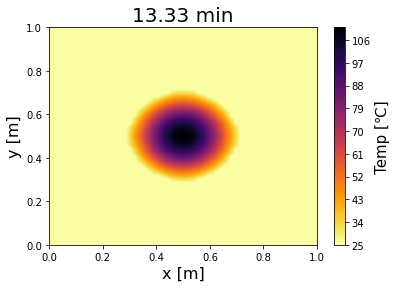

(110.10082330961109, 25.0)

In [11]:
# 展示结果
my_cmap = plt.get_cmap('inferno_r')
t_check=80 # 计算时，每隔10秒保存一次，所以检查的实际世界是 t_check*10
pc=plt.contourf(X,Y,TT[t_check],100,cmap=my_cmap)
cb=plt.colorbar(pc)
cb.set_label('Temp [℃]',fontsize=15)
plt.title('{:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

## 4.3 提高计算速度

因为在循环过程中需要求解矩阵，numba在这里用不了（报错，没细看具体原因是什么）。在网上搜索python求解稀疏矩阵，决定尝试使用scipy.sparse.linalg库

编程的逻辑顺序没有改变，只是在求解上作出改进

In [12]:
import scipy.sparse.linalg

In [13]:
def solve2(HT,Z):
    cT=HT[0].flatten().copy()  # 当前时刻温度 current T
    cf=0
    FF=[-F,-F,1+4*F,-F,-F]
    K=np.zeros((n*n,n*n))
    for j in range(n):     # 因为当前节点要通过前后，左右的节点来获得
        for i in range(n): # 现在这种写法是因为x，y方向的设置是一样的
            if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                idd=(j-1)*n+i
                idl=j*n+i-1
                idm=j*n+i
                idr=j*n+i+1
                idu=(j+1)*n+i
                idlist=[idd,idl,idm,idr,idu]
                K[idm,idlist]=FF
            else:
                idm=j*n+i
                K[idm,idm]=1

    for tt in range(1,times+1):
        
        U=np.zeros(n*n)
        # 下一个时刻温度 next T
        nT=cT.copy()    # 这里copy的主要是环境温度，材料温度会进行迭代

        
        U[:]=scipy.sparse.linalg.spsolve(K,nT)
        cT=U.copy()   # 更新 
        if tt%f==0:
            cf+=1
            HT[cf]=cT.reshape((n,n)).copy()
    
    return HT

In [14]:
n=60
x,y=np.linspace(0,1,n),np.linspace(0,1,n)

X,Y=np.meshgrid(x,y)
Z=((X-0.5)**2+(Y-0.5)**2<=0.04)

T_am=25
T_Fe=600
T=np.ones((n,n))*T_am  # 环境温度
T[Z]=T_Fe             # 铁饼温度

t=3600         # 也就是 1h
dt=1
times=int(t/dt)        # 循环次数
storage=360       # 要存储的时刻次数
f=times/storage   # 存储判断条件

dx=x[1]-x[0]
F=(alpha*dt)/(dx**2)
F,times,f

(0.07660049670786648, 3600, 10.0)

In [15]:

TT2=np.zeros((storage+1,n,n))

TT2[0]=T

In [16]:
# 计算所用时间
start=time.time()
TT2=solve2(TT2,Z)
t2=time.time()-start
t2

D:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


323.10088658332825

In [17]:
t1/t2

5.184953266777208

已经比之前要快了，但还是有改进的地方。根据提示把K矩阵改为csc格式的。

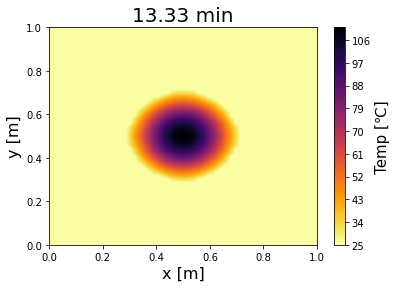

(110.10082330961109, 25.0)

In [18]:
# 展示结果
my_cmap = plt.get_cmap('inferno_r')
t_check=80 # 计算时，每隔10秒保存一次，所以检查的实际世界是 t_check*10
pc=plt.contourf(X,Y,TT2[t_check],100,cmap=my_cmap)
cb=plt.colorbar(pc)
cb.set_label('Temp [℃]',fontsize=15)
plt.title('{:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

## 4.4 提高计算速度2

In [19]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

In [20]:
def solve3(HT,Z):
    cT=HT[0].flatten().copy()  # 当前时刻温度 current T
    cf=0
    FF=[-F,-F,1+4*F,-F,-F]     # 线性函数参数
    K=np.zeros((n*n,n*n))      # 线性函数参数矩阵
    for j in range(n):     # 这里是因为知道不会出现j-1,j+1益处的情况
        for i in range(n): 
            if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                idd=(j-1)*n+i
                idl=j*n+i-1
                idm=j*n+i
                idr=j*n+i+1
                idu=(j+1)*n+i
                idlist=[idd,idl,idm,idr,idu]
                K[idm,idlist]=FF
            else:
                idm=j*n+i
                K[idm,idm]=1
    K_csc=csc_matrix(K)     # 把K矩阵写出csc格式； 如果需要返回原格式，K_csc.toarray()
    
    for tt in range(1,times+1):
        # 下一个时刻温度 next T
        nT=cT.copy()    # 这里copy的主要是环境温度，材料温度会进行迭代
        U=scipy.sparse.linalg.spsolve(K_csc,nT)
        cT=U.copy()   # 更新 
        if tt%f==0:
            cf+=1
            HT[cf]=cT.reshape((n,n)).copy()
    
    return HT

In [21]:
n=60
x,y=np.linspace(0,1,n),np.linspace(0,1,n)

X,Y=np.meshgrid(x,y)
Z=((X-0.5)**2+(Y-0.5)**2<=0.04)

T_am=25
T_Fe=600
T=np.ones((n,n))*T_am  # 环境温度
T[Z]=T_Fe             # 铁饼温度

t=3600         # 也就是 1h
dt=1
times=int(t/dt)        # 循环次数
storage=360       # 要存储的时刻次数
f=times/storage   # 存储判断条件

dx=x[1]-x[0]
F=(alpha*dt)/(dx**2)
F,times,f

(0.07660049670786648, 3600, 10.0)

In [22]:
TT3=np.zeros((storage+1,n,n))

TT3[0]=T

In [23]:
# 计算所用时间
start=time.time()
TT3=solve3(TT3,Z)
t3=time.time()-start
t3

7.5267274379730225

In [24]:
t1/t2,t1/t3

(5.184953266777208, 222.57521760878254)

可以看到改进后的计算速度比之前快百倍

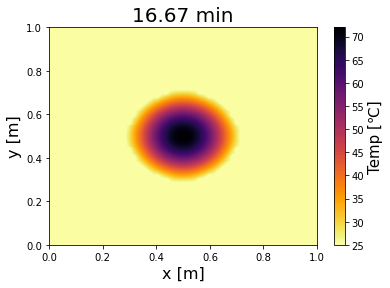

(71.99029769659226, 25.0)

In [25]:
my_cmap = plt.get_cmap('inferno_r')
t_check=100 # 计算时，每隔10秒保存一次，所以检查的实际世界是 t_check*10
pc=plt.contourf(X,Y,TT3[t_check],100,cmap=my_cmap)
cb=plt.colorbar(pc)
cb.set_label('Temp [℃]',fontsize=15)
plt.title('{:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

改变节点个数，看一下效果

In [26]:
n=200
x,y=np.linspace(0,1,n),np.linspace(0,1,n)

X,Y=np.meshgrid(x,y)
Z=((X-0.5)**2+(Y-0.5)**2<=0.04)

T_am=25
T_Fe=600
T=np.ones((n,n))*T_am  # 环境温度
T[Z]=T_Fe             # 铁饼温度

t=3600         # 也就是 1h
dt=1
times=int(t/dt)        # 循环次数
storage=360       # 要存储的时刻次数
f=times/storage   # 存储判断条件

dx=x[1]-x[0]
F=(alpha*dt)/(dx**2)
F,times,f

(0.8714324246274693, 3600, 10.0)

In [27]:
TT4=np.zeros((storage+1,n,n))

TT4[0]=T

In [28]:
# 计算所用时间
start=time.time()
TT4=solve3(TT4,Z)
t4=time.time()-start
t4

130.50625348091125

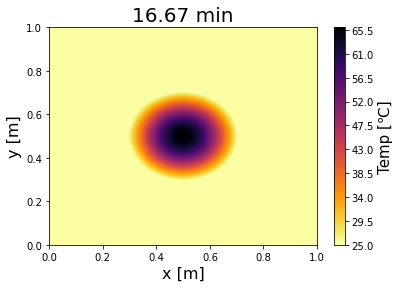

(71.99029769659226, 25.0)

In [29]:
my_cmap = plt.get_cmap('inferno_r')
t_check=100 # 计算时，每隔10秒保存一次，所以检查的实际世界是 t_check*10
pc=plt.contourf(X,Y,TT4[t_check],100,cmap=my_cmap)
cb=plt.colorbar(pc)
cb.set_label('Temp [℃]',fontsize=15)
plt.title('{:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

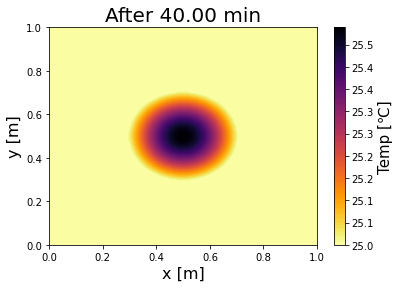

(25.522098157509184, 25.0)

In [30]:
my_cmap = plt.get_cmap('inferno_r')
t_check=240
pc=plt.contourf(X,Y,TT4[t_check],100,cmap=my_cmap) # colorbar固定时，要把t_check置为0
cb=plt.colorbar(pc,format='%.1f')
cb.set_label('Temp [℃]', fontsize=15)
# plt.contourf(X,Y,TT[t_check],100,cmap=my_cmap,vmin=T_am,vmax=T_Fe) # colorbar固定时使用
plt.title('After {:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT4[t_check]),np.min(TT4[t_check]))

# 4. 数据展示——动画

In [31]:
from matplotlib import animation

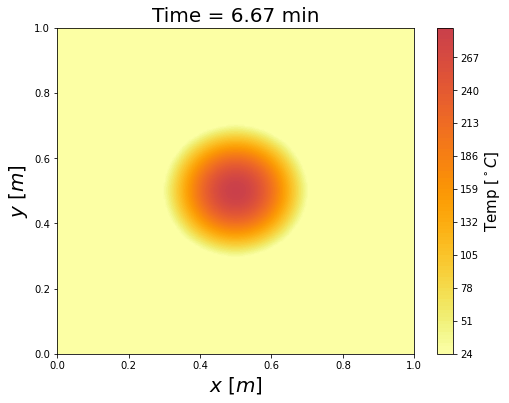

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
a = ax.contourf(X,Y,TT4[40], 100, cmap=my_cmap,
                    vmin=T_am, vmax = T_Fe)
cbar = fig.colorbar(a)
cbar.set_label('Temp [$^\circ C$]', fontsize=15)
ax.set_title('Time = {:.2f} min'.format(40*f/60), fontsize=20)
ax.set_xlabel('$x$ [$m$]',fontsize=20)
ax.set_ylabel('$y$ [$m$]',fontsize=20)
plt.show()

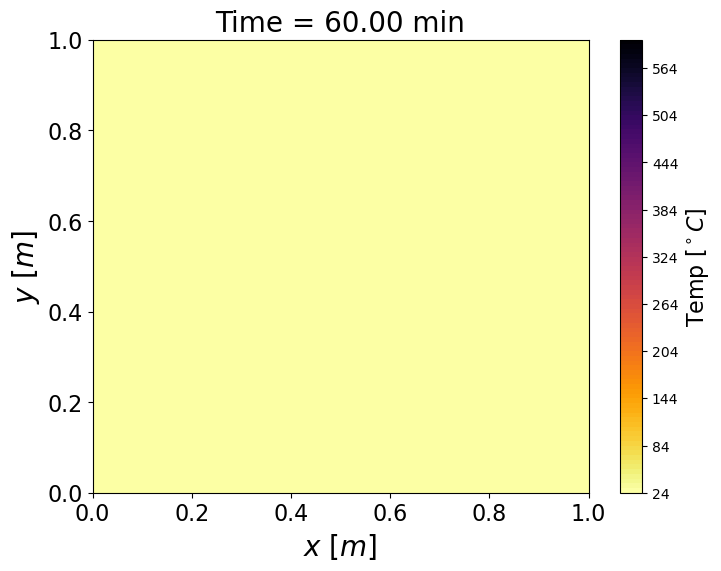

In [35]:
# 这个运行时间较长，现有参数下约十几秒
# 可以先把frames设定的小一些，如果效果满意再按实际设置
my_cmap = plt.get_cmap('inferno_r')
def init():
    a = ax.contourf(X,Y,TT4[0], 100, cmap=my_cmap,
                    vmin=T_am, vmax = T_Fe)
    cbar = fig.colorbar(a)
    cbar.set_label('Temp [$^\circ C$]',fontsize=16)

def animate(i):
    ax.clear()
    ax.contourf(X,Y,TT4[i], 100, cmap=my_cmap,
                vmin=T_am, vmax = T_Fe)
    ax.set_title('Time = {:.2f} min'.format(f*i/60), fontsize=20)
    ax.tick_params(axis='both',labelsize=16)
    ax.set_xlabel('$x$ [$m$]',fontsize=20)
    ax.set_ylabel('$y$ [$m$]',fontsize=20)
    return fig,

fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(1,storage+1), interval=100)
ani.save('cool_ybhjuu.gif',writer='pillow',fps=30)